model_name = inception 
data_input =  face 
win_len = 200 
hop = 50 
optim = Adam 
lr=1e-06 
mask_y_len = 40 mask_x_len = 10         
vad_min = 0.5  
g1, g0 = Ataxia Control 
batch_train = 8 batch_val = 8  
n_epochs = 100         
split = individ 
derivatives = True 
pose_pnts_small = face_mouse
subj data train: 115, Ataxia:84,Control:31
subj data val: 30, Ataxia:18,Control:12
data train: 4253, Ataxia:2939,Control:1314 
data val: 1230, Ataxia:734,Control:496, ratio:0.68 
Finished Training in 18.699746465682985
Maxx val acc: 58.333333333333336


<ipython-input-1-8f2ca113338c>:284: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


model_name = inception 
data_input =  face 
win_len = 300 
hop = 50 
optim = Adam 
lr=1e-06 
mask_y_len = 40 mask_x_len = 10         
vad_min = 0.5  
g1, g0 = Ataxia Control 
batch_train = 8 batch_val = 8  
n_epochs = 100         
split = individ 
derivatives = True 
pose_pnts_small = face_mouse
subj data train: 115, Ataxia:84,Control:31
subj data val: 30, Ataxia:18,Control:12
data train: 4139, Ataxia:2861,Control:1278 
data val: 1194, Ataxia:710,Control:484, ratio:0.68 
Finished Training in 19.686096318562825
Maxx val acc: 57.49664429530201


<ipython-input-1-8f2ca113338c>:284: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


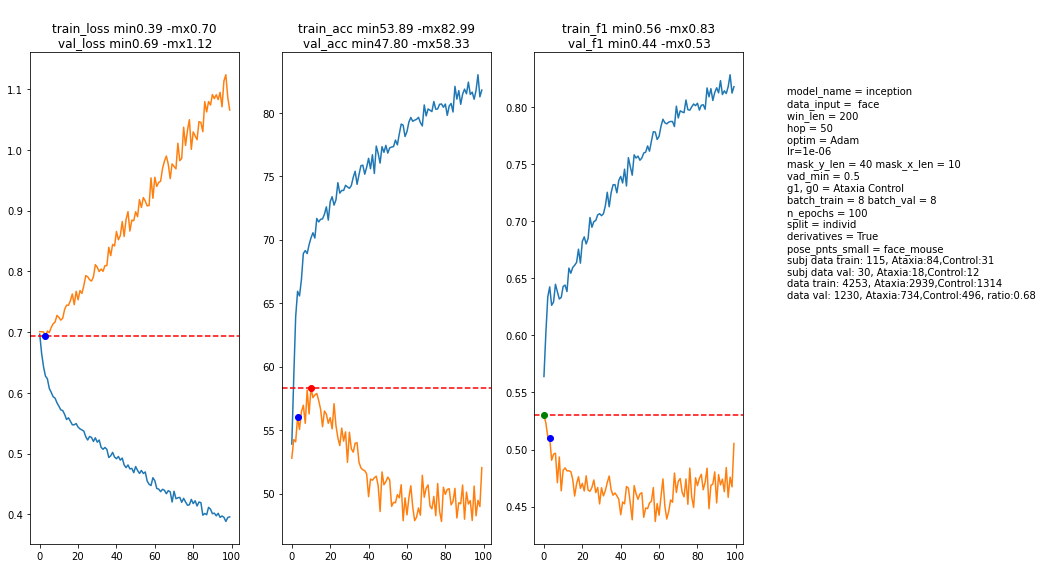

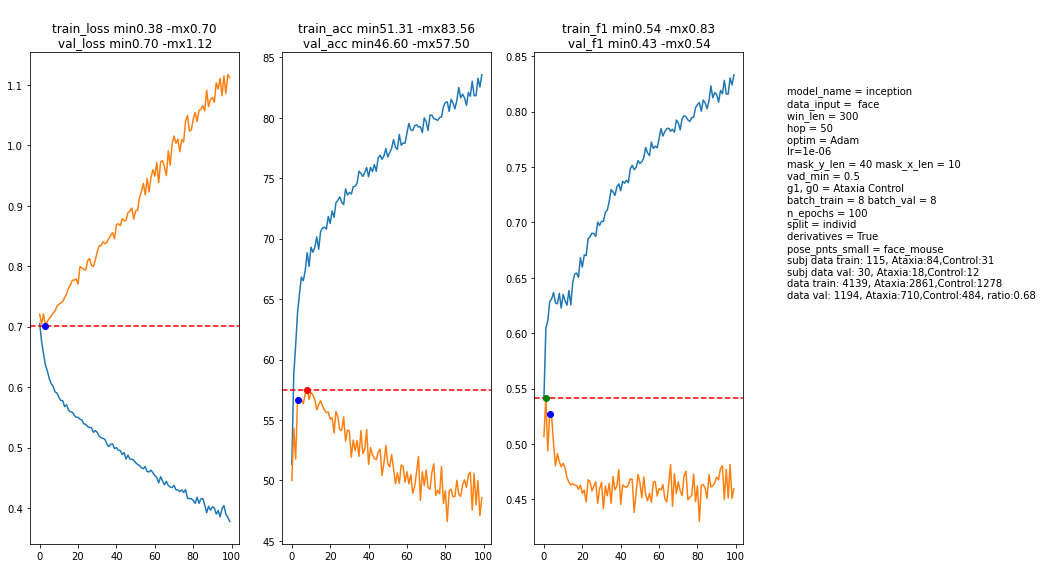

In [1]:
import numpy as np
import time
import pickle
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchaudio.transforms as T
from DL_utils import get_data, MyDataset, MyDataset_2data, inception_model, FCNN_short, binary_acc, multiinception_model

win_len = 100
hop = 100
vad_min = .5
g1, g0 = 'Ataxia', 'Control'
batch_train = 8
batch_val = 8  # all if -1
dev_num = 1
data_input = "face" #"audio"  # "multi"  #   
n_epochs = 100
split = 'individ'
optim = "Adam"  # "SGD"#
mask_y_len = 40
mask_x_len = 10
lr = 1e-6
model_name = "inception"  # "FCNN_short"
pose_pnts_small = "face_mouse" # "face_mouse" or True
derivatives= True
save = True

for win_len in [200, 300]:
    for hop in [50 ]:
        params_string = f"model_name = {model_name} \ndata_input =  {data_input} \nwin_len = {win_len} \nhop = {hop} \noptim = {optim} \nlr={lr} \nmask_y_len = {mask_y_len} mask_x_len = {mask_x_len} \
        \nvad_min = {vad_min}  \ng1, g0 = {g1} {g0} \nbatch_train = {batch_train} batch_val = {batch_val}  \nn_epochs = {n_epochs} \
        \nsplit = {split} \nderivatives = {derivatives} \npose_pnts_small = {pose_pnts_small}"
        print(params_string)

        # Get dataset
        fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_flhNone-30_min_win4_audio_commFs50.pickle'
        # fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_dwnsmp-4_flhNone-30_audio.pickle'
        with open(fname, "rb") as f:
            dataset = pickle.load(f)

        if pose_pnts_small:
            # reduce num points face
            with open("inx_mp2op.pickle", "rb") as f:
                pnts_inx = pickle.load(f)
            if pose_pnts_small == "face_mouse":
                subset = np.arange(36, 70)
                pnts_inx = np.array(pnts_inx)[subset]
            for k in list(dataset)[:1]:
                dataset[k]['ts'] = [d[:, pnts_inx, :] for d in dataset[k]['ts']]

        # Remove other groups
        ids = list(dataset)
        for k in ids:
            if dataset[k]['beh']['gen_diagnosis'] not in [g1, g0]:
                del dataset[k]

        # Split data into groups
        ids = np.array(list(dataset))
        labels = [dataset[k]['beh']['gen_diagnosis'] for k in ids]
        labels = [1 if l == g1 else 0 for l in labels]


        if split == "strat":
            train_inx, val_inx = train_test_split(list(range(len(labels))), test_size=.3,
                                                random_state=1, stratify=labels)
        elif split == "individ":
            IDs = [i[:5] for i in list(dataset.keys())]
            idxs, inx, groups = np.unique(IDs, return_index=True, return_inverse=True)
            gss = GroupShuffleSplit(1, train_size=.8, random_state=1)
            train_inx, val_inx = next(
                gss.split(list(range(len(labels))), None, groups))

        data_train = {k: v for k, v in dataset.items() if k in ids[train_inx]}
        data_val = {k: v for k, v in dataset.items() if k in ids[val_inx]}

        labels = np.array(labels)
        
        l1 = f"subj data train: {len(data_train)}, {g1}:{sum(labels[train_inx]== 1)},{g0}:{sum(labels[train_inx]== 0)}"
        l2 = f"subj data val: {len(data_val)}, {g1}:{sum(labels[val_inx]== 1)},{g0}:{sum(labels[val_inx]== 0)}"
        print(l1)
        print(l2)
        
        x_ts_train, x_S_train, y_train, sbj_ids_train, inx_win = get_data(
            data_train, win_len, hop, vad_min, pose_dims=2,derivatives=derivatives)
        x_ts_val, x_S_val, y_val, sbj_ids_val, _ = get_data(
            data_val, win_len, hop, vad_min, pose_dims=2 ,derivatives=derivatives)
        
        y_train = [1 if l == g1 else 0 for l in y_train]
        y_val = [1 if l == g1 else 0 for l in y_val]

        val_1 = sum(y_val)
        val_0 = abs(val_1 - len(y_val))
        
        l3 = f"data train: {len(x_ts_train)}, {g1}:{sum(y_train)},{g0}:{abs(sum(y_train) - len(y_train))} "
        l4 = f"data val: {len(x_ts_val)}, {g1}:{val_1},{g0}:{val_0}, ratio:{val_0/val_1 :.2f} "
        print(l3)
        print(l4)
        
        # Create Dataloaders
        transform = transforms.Compose([
            T.TimeMasking(time_mask_param=mask_x_len),
            T.FrequencyMasking(freq_mask_param=mask_y_len)
        ])

        if data_input == "face":
            dataset_t = MyDataset(x_ts_train, y_train, transform=transform)
            dataset_v = MyDataset(x_ts_val, y_val, transform=transform)
        elif data_input == "audio":
            dataset_t = MyDataset(x_S_train, y_train, transform=transform)
            dataset_v = MyDataset(x_S_val, y_val, transform=transform)
        elif data_input == "multi":
            dataset_t = MyDataset_2data(
                x_ts_train, x_S_train, y_train, transform=transform)
            dataset_v = MyDataset_2data(x_ts_val, x_S_val, y_val, transform=transform)

        dataloader_t = DataLoader(dataset_t, batch_size=batch_train,
                                shuffle=True, drop_last=True, pin_memory=True)
        batch_size = len(dataset_v) if batch_val < 0 else batch_val
        dataloader_v = DataLoader(
            dataset_v, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        if device == "cuda" and dev_num is not None:
            device = torch.device(f'cuda:{dev_num}')

        # Set up ML
        if data_input == "multi":
            in_chans1 = dataloader_t.dataset.data_pose[0].shape[0]
            in_chans2 = dataloader_t.dataset.data_aud[0].shape[0]
            net = multiinception_model(in_chans1, in_chans2)
            net_name = "inception"
        elif model_name == "FCNN_short":
            net_name = model_name
            net = FCNN_short()
        else:
            in_chans = dataloader_t.dataset.data[0].shape[0]
            net = inception_model(in_chans)
            net_name = "inception"

        t0 = time.time()
        if device == "cuda" and dev_num is None:
            net = nn.DataParallel(net)
        net.to(device)

        criterion = nn.CrossEntropyLoss().to(device)
        if optim == "Adam":
            optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.01)
        elif optim == "SGD":
            optimizer = torch.optim.SGD(
                net.parameters(), lr=lr, momentum=0.9, weight_decay=0.01)

        train_f1 = torchmetrics.F1(num_classes=2, average='weighted')
        train_f1.to(device)
        metrics = {k: [] for k in ["train_loss", "train_acc",
                                "val_loss", "val_acc", "train_f1", "val_f1"]}
        for epoch in range(n_epochs):  # loop over the dataset multiple times

            running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
            for i, data in enumerate(dataloader_t):
                if data_input == "multi":
                    inputs1, inputs2, labels = data
                    inputs1 = inputs1.to(device)
                    inputs2 = inputs2.to(device)
                else:
                    inputs, labels = data
                    if model_name == "FCNN_short":
                        inputs = torch.unsqueeze(inputs, dim=1)
                    inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                labels = labels.type(torch.long)
                labels = labels.unsqueeze(1)
                
                # forward + backward + optimize
                if data_input == "multi":
                    outputs = net(inputs1, inputs2)
                else:
                    outputs = net(inputs)
                loss = criterion(outputs, labels[:, 0])

                outputs = torch.argmax(F.softmax(outputs, dim=1), dim=1)
                acc = binary_acc(outputs, labels[:, 0])
                f1 = train_f1(outputs, labels[:, 0])

                loss.backward()
                optimizer.step()

                running_f1 += f1.item()
                running_loss += loss.item()
                running_acc += acc.item()

            metrics["train_loss"].append(running_loss / len(dataloader_t))
            metrics["train_acc"].append(running_acc / len(dataloader_t))
            metrics["train_f1"].append(running_f1 / len(dataloader_t))

            running_loss, running_acc, running_f1 = 0.0, 0., 0.0
            for i, data in enumerate(dataloader_v):
                if data_input == "multi":
                    inputs1, inputs2, labels = data
                    inputs1 = inputs1.to(device)
                    inputs2 = inputs2.to(device)
                else:
                    inputs, labels = data
                    if model_name == "FCNN_short":
                        inputs = torch.unsqueeze(inputs, dim=1)
                    inputs = inputs.to(device)
                labels = labels.to(device)

                labels = labels.type(torch.long)
                labels = labels.unsqueeze(1)

                # forward
                if data_input == "multi":
                    outputs = net(inputs1, inputs2)
                else:
                    outputs = net(inputs)
                loss = criterion(outputs, labels[:, 0])

                outputs = torch.argmax(F.softmax(outputs, dim=1), dim=1)
                acc = binary_acc(outputs, labels[:, 0])
                f1 = train_f1(outputs, labels[:, 0])

                running_f1 += f1.item()
                running_loss += loss.item()
                running_acc += acc.item()

            metrics["val_loss"].append(running_loss / len(dataloader_v))
            metrics["val_acc"].append(running_acc / len(dataloader_v))
            metrics["val_f1"].append(running_f1 / len(dataloader_v))

            # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
            #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
            #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
            #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
            #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
            #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

        t1 = time.time()
        ttot = t1 - t0
        print(f'Finished Training in {ttot/60}')


        title = net_name

        fig, axs = plt.subplots(1, 4, figsize=(15, 8))
        # fig.canvas.set_window_title(title)
        for ax, tt in zip(axs.flatten(), ['train_loss', 'train_acc', 'train_f1']):
            ax.plot(metrics[tt])
            mn, mx = min(metrics[tt]), max(metrics[tt])
            ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
            
        for ax, tt in zip(axs.flatten(), ['val_loss', 'val_acc',  "val_f1"]):
            ax.plot(metrics[tt])
            mn, mx = min(metrics[tt]), max(metrics[tt])
            tt =  "\n" + ax.get_title() + "\n" + tt
            ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
            
        print(f"Maxx val acc: {max(metrics['val_acc'])}")
        axs.flatten()[0].axhline(min(metrics['val_loss']), color="r", linestyle="--")
        loss_min = np.argmin(metrics['val_loss'])
        axs.flatten()[0].plot(loss_min, min(metrics['val_loss']), "bo")
        axs.flatten()[1].plot(loss_min, metrics['val_acc'][loss_min], "bo")
        axs.flatten()[2].plot(loss_min, metrics['val_f1'][loss_min], "bo")

        axs.flatten()[1].axhline(max(metrics['val_acc']), color="r", linestyle="--")
        axs.flatten()[1].plot(np.argmax(metrics['val_acc']),
                            max(metrics['val_acc']), "ro")

        axs.flatten()[2].axhline(max(metrics['val_f1']), color="r", linestyle="--")
        axs.flatten()[2].plot(np.argmax(metrics['val_f1']),
                            max(metrics['val_f1']), "go")

        axs[3].axis('off')
        axs[3].text(0,.5, params_string + f'\n{l1}\n{l2}\n{l3}\n{l4}')
        
        fig.tight_layout()
        fig.show()
        
        if save:
            fig.savefig(f"result_figs/{title}_{data_input}_{win_len}wz_{hop}st_{g1}vs{g0}_mask_y_len{mask_y_len}_mask_x_len{mask_x_len}_lr{lr}_deriv{derivatives}_pntsubset{pose_pnts_small}_optim{optim}_valBatch{batch_val}_{round(ttot/60)}mintime.png")

model_name = inception 
data_input =  face 
win_len = 200 
hop = 50 
optim = Adam 
lr=1e-06 
mask_y_len = 40 mask_x_len = 10         
vad_min = 0.5  
g1, g0 = Ataxia Control 
batch_train = 8 batch_val = 8  
n_epochs = 100         
split = individ 
derivatives = True 
pose_pnts_small = True
subj data train: 115, Ataxia:84,Control:31
subj data val: 30, Ataxia:18,Control:12
data train: 4253, Ataxia:2939,Control:1314 
data val: 1230, Ataxia:734,Control:496, ratio:0.68 
Finished Training in 19.906704608599345
Maxx val acc: 58.08496732026144


<ipython-input-3-1a2dd866032f>:284: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


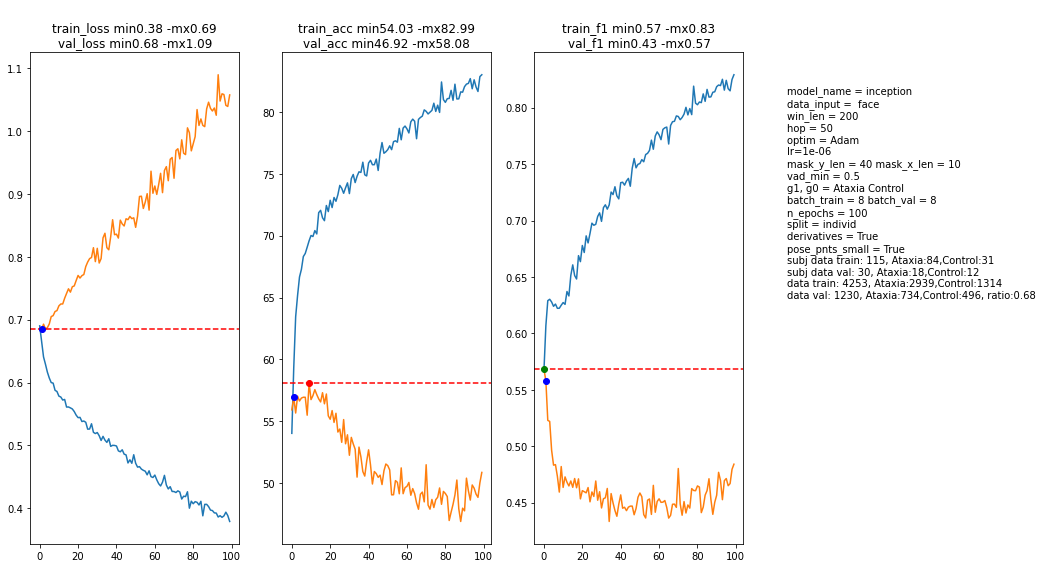

In [3]:
import numpy as np
import time
import pickle
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchaudio.transforms as T
from DL_utils import get_data, MyDataset, MyDataset_2data, inception_model, FCNN_short, binary_acc, multiinception_model

win_len = 100
hop = 100
vad_min = .5
g1, g0 = 'Ataxia', 'Control'
batch_train = 8
batch_val = 8  # all if -1
dev_num = 1
data_input =  "face" #"multi"  # "audio"  #  
n_epochs = 100
split = 'individ'
optim = "Adam"  # "SGD"#
mask_y_len = 40
mask_x_len = 10
lr = 1e-6
model_name = "inception"  # "FCNN_short"
pose_pnts_small = True # "face_mouse" # "face_mouse" or True
derivatives= True
save = True

for win_len in [200]:
    for hop in [50 ]:
        params_string = f"model_name = {model_name} \ndata_input =  {data_input} \nwin_len = {win_len} \nhop = {hop} \noptim = {optim} \nlr={lr} \nmask_y_len = {mask_y_len} mask_x_len = {mask_x_len} \
        \nvad_min = {vad_min}  \ng1, g0 = {g1} {g0} \nbatch_train = {batch_train} batch_val = {batch_val}  \nn_epochs = {n_epochs} \
        \nsplit = {split} \nderivatives = {derivatives} \npose_pnts_small = {pose_pnts_small}"
        print(params_string)

        # Get dataset
        fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_flhNone-30_min_win4_audio_commFs50.pickle'
        # fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_dwnsmp-4_flhNone-30_audio.pickle'
        with open(fname, "rb") as f:
            dataset = pickle.load(f)

        if pose_pnts_small:
            # reduce num points face
            with open("inx_mp2op.pickle", "rb") as f:
                pnts_inx = pickle.load(f)
            if pose_pnts_small == "face_mouse":
                subset = np.arange(36, 70)
                pnts_inx = np.array(pnts_inx)[subset]
            for k in list(dataset)[:1]:
                dataset[k]['ts'] = [d[:, pnts_inx, :] for d in dataset[k]['ts']]

        # Remove other groups
        ids = list(dataset)
        for k in ids:
            if dataset[k]['beh']['gen_diagnosis'] not in [g1, g0]:
                del dataset[k]

        # Split data into groups
        ids = np.array(list(dataset))
        labels = [dataset[k]['beh']['gen_diagnosis'] for k in ids]
        labels = [1 if l == g1 else 0 for l in labels]


        if split == "strat":
            train_inx, val_inx = train_test_split(list(range(len(labels))), test_size=.3,
                                                random_state=1, stratify=labels)
        elif split == "individ":
            IDs = [i[:5] for i in list(dataset.keys())]
            idxs, inx, groups = np.unique(IDs, return_index=True, return_inverse=True)
            gss = GroupShuffleSplit(1, train_size=.8, random_state=1)
            train_inx, val_inx = next(
                gss.split(list(range(len(labels))), None, groups))

        data_train = {k: v for k, v in dataset.items() if k in ids[train_inx]}
        data_val = {k: v for k, v in dataset.items() if k in ids[val_inx]}

        labels = np.array(labels)
        
        l1 = f"subj data train: {len(data_train)}, {g1}:{sum(labels[train_inx]== 1)},{g0}:{sum(labels[train_inx]== 0)}"
        l2 = f"subj data val: {len(data_val)}, {g1}:{sum(labels[val_inx]== 1)},{g0}:{sum(labels[val_inx]== 0)}"
        print(l1)
        print(l2)
        
        x_ts_train, x_S_train, y_train, sbj_ids_train, inx_win = get_data(
            data_train, win_len, hop, vad_min, pose_dims=2,derivatives=derivatives)
        x_ts_val, x_S_val, y_val, sbj_ids_val, _ = get_data(
            data_val, win_len, hop, vad_min, pose_dims=2 ,derivatives=derivatives)
        
        y_train = [1 if l == g1 else 0 for l in y_train]
        y_val = [1 if l == g1 else 0 for l in y_val]

        val_1 = sum(y_val)
        val_0 = abs(val_1 - len(y_val))
        
        l3 = f"data train: {len(x_ts_train)}, {g1}:{sum(y_train)},{g0}:{abs(sum(y_train) - len(y_train))} "
        l4 = f"data val: {len(x_ts_val)}, {g1}:{val_1},{g0}:{val_0}, ratio:{val_0/val_1 :.2f} "
        print(l3)
        print(l4)
        
        # Create Dataloaders
        transform = transforms.Compose([
            T.TimeMasking(time_mask_param=mask_x_len),
            T.FrequencyMasking(freq_mask_param=mask_y_len)
        ])

        if data_input == "face":
            dataset_t = MyDataset(x_ts_train, y_train, transform=transform)
            dataset_v = MyDataset(x_ts_val, y_val, transform=transform)
        elif data_input == "audio":
            dataset_t = MyDataset(x_S_train, y_train, transform=transform)
            dataset_v = MyDataset(x_S_val, y_val, transform=transform)
        elif data_input == "multi":
            dataset_t = MyDataset_2data(
                x_ts_train, x_S_train, y_train, transform=transform)
            dataset_v = MyDataset_2data(x_ts_val, x_S_val, y_val, transform=transform)

        dataloader_t = DataLoader(dataset_t, batch_size=batch_train,
                                shuffle=True, drop_last=True, pin_memory=True)
        batch_size = len(dataset_v) if batch_val < 0 else batch_val
        dataloader_v = DataLoader(
            dataset_v, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        if device == "cuda" and dev_num is not None:
            device = torch.device(f'cuda:{dev_num}')

        # Set up ML
        if data_input == "multi":
            in_chans1 = dataloader_t.dataset.data_pose[0].shape[0]
            in_chans2 = dataloader_t.dataset.data_aud[0].shape[0]
            net = multiinception_model(in_chans1, in_chans2)
            net_name = "inception"
        elif model_name == "FCNN_short":
            net_name = model_name
            net = FCNN_short()
        else:
            in_chans = dataloader_t.dataset.data[0].shape[0]
            net = inception_model(in_chans)
            net_name = "inception"

        t0 = time.time()
        if device == "cuda" and dev_num is None:
            net = nn.DataParallel(net)
        net.to(device)

        criterion = nn.CrossEntropyLoss().to(device)
        if optim == "Adam":
            optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.01)
        elif optim == "SGD":
            optimizer = torch.optim.SGD(
                net.parameters(), lr=lr, momentum=0.9, weight_decay=0.01)

        train_f1 = torchmetrics.F1(num_classes=2, average='weighted')
        train_f1.to(device)
        metrics = {k: [] for k in ["train_loss", "train_acc",
                                "val_loss", "val_acc", "train_f1", "val_f1"]}
        for epoch in range(n_epochs):  # loop over the dataset multiple times

            running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
            for i, data in enumerate(dataloader_t):
                if data_input == "multi":
                    inputs1, inputs2, labels = data
                    inputs1 = inputs1.to(device)
                    inputs2 = inputs2.to(device)
                else:
                    inputs, labels = data
                    if model_name == "FCNN_short":
                        inputs = torch.unsqueeze(inputs, dim=1)
                    inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                labels = labels.type(torch.long)
                labels = labels.unsqueeze(1)
                
                # forward + backward + optimize
                if data_input == "multi":
                    outputs = net(inputs1, inputs2)
                else:
                    outputs = net(inputs)
                loss = criterion(outputs, labels[:, 0])

                outputs = torch.argmax(F.softmax(outputs, dim=1), dim=1)
                acc = binary_acc(outputs, labels[:, 0])
                f1 = train_f1(outputs, labels[:, 0])

                loss.backward()
                optimizer.step()

                running_f1 += f1.item()
                running_loss += loss.item()
                running_acc += acc.item()

            metrics["train_loss"].append(running_loss / len(dataloader_t))
            metrics["train_acc"].append(running_acc / len(dataloader_t))
            metrics["train_f1"].append(running_f1 / len(dataloader_t))

            running_loss, running_acc, running_f1 = 0.0, 0., 0.0
            for i, data in enumerate(dataloader_v):
                if data_input == "multi":
                    inputs1, inputs2, labels = data
                    inputs1 = inputs1.to(device)
                    inputs2 = inputs2.to(device)
                else:
                    inputs, labels = data
                    if model_name == "FCNN_short":
                        inputs = torch.unsqueeze(inputs, dim=1)
                    inputs = inputs.to(device)
                labels = labels.to(device)

                labels = labels.type(torch.long)
                labels = labels.unsqueeze(1)

                # forward
                if data_input == "multi":
                    outputs = net(inputs1, inputs2)
                else:
                    outputs = net(inputs)
                loss = criterion(outputs, labels[:, 0])

                outputs = torch.argmax(F.softmax(outputs, dim=1), dim=1)
                acc = binary_acc(outputs, labels[:, 0])
                f1 = train_f1(outputs, labels[:, 0])

                running_f1 += f1.item()
                running_loss += loss.item()
                running_acc += acc.item()

            metrics["val_loss"].append(running_loss / len(dataloader_v))
            metrics["val_acc"].append(running_acc / len(dataloader_v))
            metrics["val_f1"].append(running_f1 / len(dataloader_v))

            # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
            #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
            #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
            #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
            #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
            #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

        t1 = time.time()
        ttot = t1 - t0
        print(f'Finished Training in {ttot/60}')


        title = net_name

        fig, axs = plt.subplots(1, 4, figsize=(15, 8))
        # fig.canvas.set_window_title(title)
        for ax, tt in zip(axs.flatten(), ['train_loss', 'train_acc', 'train_f1']):
            ax.plot(metrics[tt])
            mn, mx = min(metrics[tt]), max(metrics[tt])
            ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
            
        for ax, tt in zip(axs.flatten(), ['val_loss', 'val_acc',  "val_f1"]):
            ax.plot(metrics[tt])
            mn, mx = min(metrics[tt]), max(metrics[tt])
            tt =  "\n" + ax.get_title() + "\n" + tt
            ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
            
        print(f"Maxx val acc: {max(metrics['val_acc'])}")
        axs.flatten()[0].axhline(min(metrics['val_loss']), color="r", linestyle="--")
        loss_min = np.argmin(metrics['val_loss'])
        axs.flatten()[0].plot(loss_min, min(metrics['val_loss']), "bo")
        axs.flatten()[1].plot(loss_min, metrics['val_acc'][loss_min], "bo")
        axs.flatten()[2].plot(loss_min, metrics['val_f1'][loss_min], "bo")

        axs.flatten()[1].axhline(max(metrics['val_acc']), color="r", linestyle="--")
        axs.flatten()[1].plot(np.argmax(metrics['val_acc']),
                            max(metrics['val_acc']), "ro")

        axs.flatten()[2].axhline(max(metrics['val_f1']), color="r", linestyle="--")
        axs.flatten()[2].plot(np.argmax(metrics['val_f1']),
                            max(metrics['val_f1']), "go")

        axs[3].axis('off')
        axs[3].text(0,.5, params_string + f'\n{l1}\n{l2}\n{l3}\n{l4}')
        
        fig.tight_layout()
        fig.show()
        
        if save:
            fig.savefig(f"result_figs/{title}_{data_input}_{win_len}wz_{hop}st_{g1}vs{g0}_mask_y_len{mask_y_len}_mask_x_len{mask_x_len}_lr{lr}_deriv{derivatives}_pntsubset{pose_pnts_small}_optim{optim}_valBatch{batch_val}_{round(ttot/60)}mintime.png")

model_name = inception 
data_input =  face 
win_len = 200 
hop = 50 
optim = Adam 
lr=1e-06 
mask_y_len = 40 mask_x_len = 10         
vad_min = 0.5  
g1, g0 = Ataxia Control 
batch_train = 8 batch_val = 8  
n_epochs = 100         
split = individ 
derivatives = True 
pose_pnts_small = False
subj data train: 115, Ataxia:84,Control:31
subj data val: 30, Ataxia:18,Control:12
data train: 4253, Ataxia:2939,Control:1314 
data val: 1230, Ataxia:734,Control:496, ratio:0.68 
Finished Training in 19.875234997272493
Maxx val acc: 59.248366013071895


<ipython-input-4-3065d81a02ba>:284: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


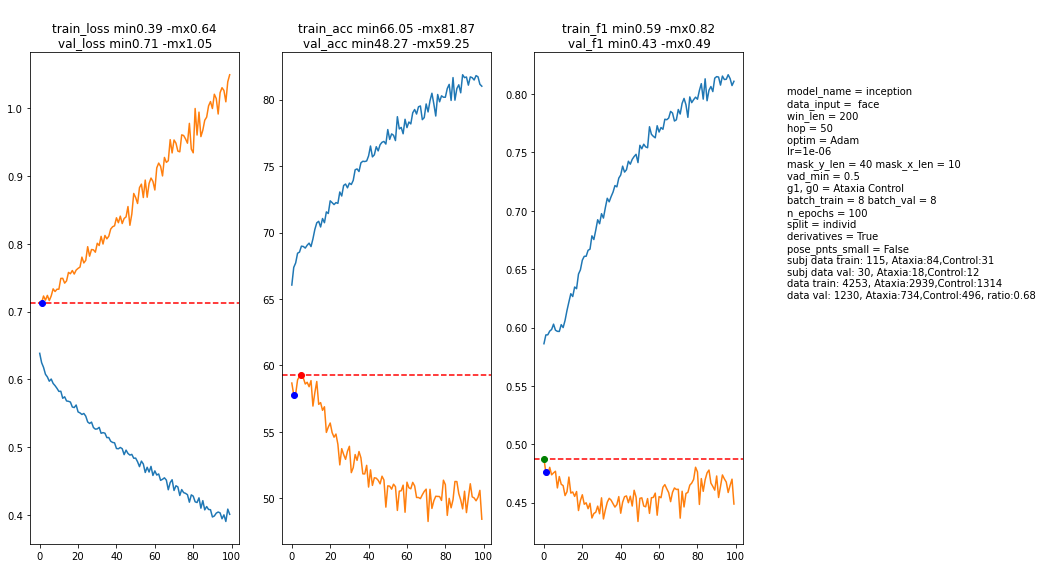

In [4]:
import numpy as np
import time
import pickle
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchaudio.transforms as T
from DL_utils import get_data, MyDataset, MyDataset_2data, inception_model, FCNN_short, binary_acc, multiinception_model

win_len = 100
hop = 100
vad_min = .5
g1, g0 = 'Ataxia', 'Control'
batch_train = 8
batch_val = 8  # all if -1
dev_num = 1
data_input =  "face" #"multi"  # "audio"  #  
n_epochs = 100
split = 'individ'
optim = "Adam"  # "SGD"#
mask_y_len = 40
mask_x_len = 10
lr = 1e-6
model_name = "inception"  # "FCNN_short"
pose_pnts_small = False # "face_mouse" # "face_mouse" or True
derivatives= True
save = True

for win_len in [200]:
    for hop in [50 ]:
        params_string = f"model_name = {model_name} \ndata_input =  {data_input} \nwin_len = {win_len} \nhop = {hop} \noptim = {optim} \nlr={lr} \nmask_y_len = {mask_y_len} mask_x_len = {mask_x_len} \
        \nvad_min = {vad_min}  \ng1, g0 = {g1} {g0} \nbatch_train = {batch_train} batch_val = {batch_val}  \nn_epochs = {n_epochs} \
        \nsplit = {split} \nderivatives = {derivatives} \npose_pnts_small = {pose_pnts_small}"
        print(params_string)

        # Get dataset
        fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_flhNone-30_min_win4_audio_commFs50.pickle'
        # fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_dwnsmp-4_flhNone-30_audio.pickle'
        with open(fname, "rb") as f:
            dataset = pickle.load(f)

        if pose_pnts_small:
            # reduce num points face
            with open("inx_mp2op.pickle", "rb") as f:
                pnts_inx = pickle.load(f)
            if pose_pnts_small == "face_mouse":
                subset = np.arange(36, 70)
                pnts_inx = np.array(pnts_inx)[subset]
            for k in list(dataset)[:1]:
                dataset[k]['ts'] = [d[:, pnts_inx, :] for d in dataset[k]['ts']]

        # Remove other groups
        ids = list(dataset)
        for k in ids:
            if dataset[k]['beh']['gen_diagnosis'] not in [g1, g0]:
                del dataset[k]

        # Split data into groups
        ids = np.array(list(dataset))
        labels = [dataset[k]['beh']['gen_diagnosis'] for k in ids]
        labels = [1 if l == g1 else 0 for l in labels]


        if split == "strat":
            train_inx, val_inx = train_test_split(list(range(len(labels))), test_size=.3,
                                                random_state=1, stratify=labels)
        elif split == "individ":
            IDs = [i[:5] for i in list(dataset.keys())]
            idxs, inx, groups = np.unique(IDs, return_index=True, return_inverse=True)
            gss = GroupShuffleSplit(1, train_size=.8, random_state=1)
            train_inx, val_inx = next(
                gss.split(list(range(len(labels))), None, groups))

        data_train = {k: v for k, v in dataset.items() if k in ids[train_inx]}
        data_val = {k: v for k, v in dataset.items() if k in ids[val_inx]}

        labels = np.array(labels)
        
        l1 = f"subj data train: {len(data_train)}, {g1}:{sum(labels[train_inx]== 1)},{g0}:{sum(labels[train_inx]== 0)}"
        l2 = f"subj data val: {len(data_val)}, {g1}:{sum(labels[val_inx]== 1)},{g0}:{sum(labels[val_inx]== 0)}"
        print(l1)
        print(l2)
        
        x_ts_train, x_S_train, y_train, sbj_ids_train, inx_win = get_data(
            data_train, win_len, hop, vad_min, pose_dims=2,derivatives=derivatives)
        x_ts_val, x_S_val, y_val, sbj_ids_val, _ = get_data(
            data_val, win_len, hop, vad_min, pose_dims=2 ,derivatives=derivatives)
        
        y_train = [1 if l == g1 else 0 for l in y_train]
        y_val = [1 if l == g1 else 0 for l in y_val]

        val_1 = sum(y_val)
        val_0 = abs(val_1 - len(y_val))
        
        l3 = f"data train: {len(x_ts_train)}, {g1}:{sum(y_train)},{g0}:{abs(sum(y_train) - len(y_train))} "
        l4 = f"data val: {len(x_ts_val)}, {g1}:{val_1},{g0}:{val_0}, ratio:{val_0/val_1 :.2f} "
        print(l3)
        print(l4)
        
        # Create Dataloaders
        transform = transforms.Compose([
            T.TimeMasking(time_mask_param=mask_x_len),
            T.FrequencyMasking(freq_mask_param=mask_y_len)
        ])

        if data_input == "face":
            dataset_t = MyDataset(x_ts_train, y_train, transform=transform)
            dataset_v = MyDataset(x_ts_val, y_val, transform=transform)
        elif data_input == "audio":
            dataset_t = MyDataset(x_S_train, y_train, transform=transform)
            dataset_v = MyDataset(x_S_val, y_val, transform=transform)
        elif data_input == "multi":
            dataset_t = MyDataset_2data(
                x_ts_train, x_S_train, y_train, transform=transform)
            dataset_v = MyDataset_2data(x_ts_val, x_S_val, y_val, transform=transform)

        dataloader_t = DataLoader(dataset_t, batch_size=batch_train,
                                shuffle=True, drop_last=True, pin_memory=True)
        batch_size = len(dataset_v) if batch_val < 0 else batch_val
        dataloader_v = DataLoader(
            dataset_v, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        if device == "cuda" and dev_num is not None:
            device = torch.device(f'cuda:{dev_num}')

        # Set up ML
        if data_input == "multi":
            in_chans1 = dataloader_t.dataset.data_pose[0].shape[0]
            in_chans2 = dataloader_t.dataset.data_aud[0].shape[0]
            net = multiinception_model(in_chans1, in_chans2)
            net_name = "inception"
        elif model_name == "FCNN_short":
            net_name = model_name
            net = FCNN_short()
        else:
            in_chans = dataloader_t.dataset.data[0].shape[0]
            net = inception_model(in_chans)
            net_name = "inception"

        t0 = time.time()
        if device == "cuda" and dev_num is None:
            net = nn.DataParallel(net)
        net.to(device)

        criterion = nn.CrossEntropyLoss().to(device)
        if optim == "Adam":
            optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.01)
        elif optim == "SGD":
            optimizer = torch.optim.SGD(
                net.parameters(), lr=lr, momentum=0.9, weight_decay=0.01)

        train_f1 = torchmetrics.F1(num_classes=2, average='weighted')
        train_f1.to(device)
        metrics = {k: [] for k in ["train_loss", "train_acc",
                                "val_loss", "val_acc", "train_f1", "val_f1"]}
        for epoch in range(n_epochs):  # loop over the dataset multiple times

            running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
            for i, data in enumerate(dataloader_t):
                if data_input == "multi":
                    inputs1, inputs2, labels = data
                    inputs1 = inputs1.to(device)
                    inputs2 = inputs2.to(device)
                else:
                    inputs, labels = data
                    if model_name == "FCNN_short":
                        inputs = torch.unsqueeze(inputs, dim=1)
                    inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                labels = labels.type(torch.long)
                labels = labels.unsqueeze(1)
                
                # forward + backward + optimize
                if data_input == "multi":
                    outputs = net(inputs1, inputs2)
                else:
                    outputs = net(inputs)
                loss = criterion(outputs, labels[:, 0])

                outputs = torch.argmax(F.softmax(outputs, dim=1), dim=1)
                acc = binary_acc(outputs, labels[:, 0])
                f1 = train_f1(outputs, labels[:, 0])

                loss.backward()
                optimizer.step()

                running_f1 += f1.item()
                running_loss += loss.item()
                running_acc += acc.item()

            metrics["train_loss"].append(running_loss / len(dataloader_t))
            metrics["train_acc"].append(running_acc / len(dataloader_t))
            metrics["train_f1"].append(running_f1 / len(dataloader_t))

            running_loss, running_acc, running_f1 = 0.0, 0., 0.0
            for i, data in enumerate(dataloader_v):
                if data_input == "multi":
                    inputs1, inputs2, labels = data
                    inputs1 = inputs1.to(device)
                    inputs2 = inputs2.to(device)
                else:
                    inputs, labels = data
                    if model_name == "FCNN_short":
                        inputs = torch.unsqueeze(inputs, dim=1)
                    inputs = inputs.to(device)
                labels = labels.to(device)

                labels = labels.type(torch.long)
                labels = labels.unsqueeze(1)

                # forward
                if data_input == "multi":
                    outputs = net(inputs1, inputs2)
                else:
                    outputs = net(inputs)
                loss = criterion(outputs, labels[:, 0])

                outputs = torch.argmax(F.softmax(outputs, dim=1), dim=1)
                acc = binary_acc(outputs, labels[:, 0])
                f1 = train_f1(outputs, labels[:, 0])

                running_f1 += f1.item()
                running_loss += loss.item()
                running_acc += acc.item()

            metrics["val_loss"].append(running_loss / len(dataloader_v))
            metrics["val_acc"].append(running_acc / len(dataloader_v))
            metrics["val_f1"].append(running_f1 / len(dataloader_v))

            # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
            #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
            #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
            #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
            #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
            #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

        t1 = time.time()
        ttot = t1 - t0
        print(f'Finished Training in {ttot/60}')


        title = net_name

        fig, axs = plt.subplots(1, 4, figsize=(15, 8))
        # fig.canvas.set_window_title(title)
        for ax, tt in zip(axs.flatten(), ['train_loss', 'train_acc', 'train_f1']):
            ax.plot(metrics[tt])
            mn, mx = min(metrics[tt]), max(metrics[tt])
            ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
            
        for ax, tt in zip(axs.flatten(), ['val_loss', 'val_acc',  "val_f1"]):
            ax.plot(metrics[tt])
            mn, mx = min(metrics[tt]), max(metrics[tt])
            tt =  "\n" + ax.get_title() + "\n" + tt
            ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
            
        print(f"Maxx val acc: {max(metrics['val_acc'])}")
        axs.flatten()[0].axhline(min(metrics['val_loss']), color="r", linestyle="--")
        loss_min = np.argmin(metrics['val_loss'])
        axs.flatten()[0].plot(loss_min, min(metrics['val_loss']), "bo")
        axs.flatten()[1].plot(loss_min, metrics['val_acc'][loss_min], "bo")
        axs.flatten()[2].plot(loss_min, metrics['val_f1'][loss_min], "bo")

        axs.flatten()[1].axhline(max(metrics['val_acc']), color="r", linestyle="--")
        axs.flatten()[1].plot(np.argmax(metrics['val_acc']),
                            max(metrics['val_acc']), "ro")

        axs.flatten()[2].axhline(max(metrics['val_f1']), color="r", linestyle="--")
        axs.flatten()[2].plot(np.argmax(metrics['val_f1']),
                            max(metrics['val_f1']), "go")

        axs[3].axis('off')
        axs[3].text(0,.5, params_string + f'\n{l1}\n{l2}\n{l3}\n{l4}')
        
        fig.tight_layout()
        fig.show()
        
        if save:
            fig.savefig(f"result_figs/{title}_{data_input}_{win_len}wz_{hop}st_{g1}vs{g0}_mask_y_len{mask_y_len}_mask_x_len{mask_x_len}_lr{lr}_deriv{derivatives}_pntsubset{pose_pnts_small}_optim{optim}_valBatch{batch_val}_{round(ttot/60)}mintime.png")

model_name = inception 
data_input =  multi 
win_len = 200 
hop = 50 
optim = Adam 
lr=1e-06 
mask_y_len = 40 mask_x_len = 10         
vad_min = 0.5  
g1, g0 = Ataxia Control 
batch_train = 8 batch_val = 8  
n_epochs = 100         
split = individ 
derivatives = True 
pose_pnts_small = True
subj data train: 115, Ataxia:84,Control:31
subj data val: 30, Ataxia:18,Control:12
data train: 4253, Ataxia:2939,Control:1314 
data val: 1230, Ataxia:734,Control:496, ratio:0.68 
Finished Training in 34.71100317239761
Maxx val acc: 73.70588235294117


<ipython-input-5-1a8fcf41e266>:284: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


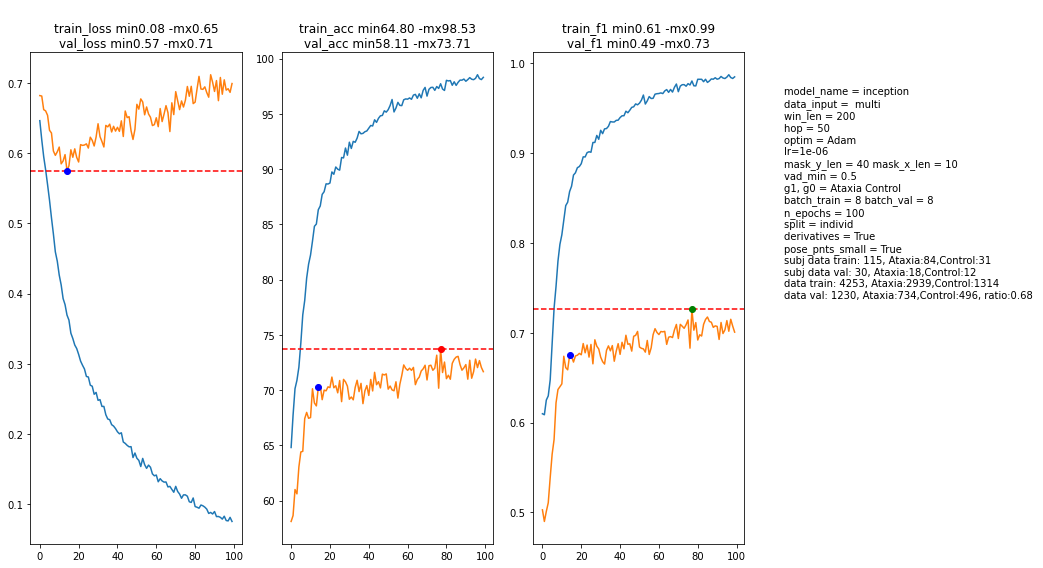

In [5]:
import numpy as np
import time
import pickle
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchaudio.transforms as T
from DL_utils import get_data, MyDataset, MyDataset_2data, inception_model, FCNN_short, binary_acc, multiinception_model

win_len = 100
hop = 100
vad_min = .5
g1, g0 = 'Ataxia', 'Control'
batch_train = 8
batch_val = 8  # all if -1
dev_num = 1
data_input = "multi" # "face" # "audio"  #  
n_epochs = 100
split = 'individ'
optim = "Adam"  # "SGD"#
mask_y_len = 40
mask_x_len = 10
lr = 1e-6
model_name = "inception"  # "FCNN_short"
pose_pnts_small = True # "face_mouse" # "face_mouse" or True
derivatives= True
save = True

for win_len in [200]:
    for hop in [50 ]:
        params_string = f"model_name = {model_name} \ndata_input =  {data_input} \nwin_len = {win_len} \nhop = {hop} \noptim = {optim} \nlr={lr} \nmask_y_len = {mask_y_len} mask_x_len = {mask_x_len} \
        \nvad_min = {vad_min}  \ng1, g0 = {g1} {g0} \nbatch_train = {batch_train} batch_val = {batch_val}  \nn_epochs = {n_epochs} \
        \nsplit = {split} \nderivatives = {derivatives} \npose_pnts_small = {pose_pnts_small}"
        print(params_string)

        # Get dataset
        fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_flhNone-30_min_win4_audio_commFs50.pickle'
        # fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_dwnsmp-4_flhNone-30_audio.pickle'
        with open(fname, "rb") as f:
            dataset = pickle.load(f)

        if pose_pnts_small:
            # reduce num points face
            with open("inx_mp2op.pickle", "rb") as f:
                pnts_inx = pickle.load(f)
            if pose_pnts_small == "face_mouse":
                subset = np.arange(36, 70)
                pnts_inx = np.array(pnts_inx)[subset]
            for k in list(dataset)[:1]:
                dataset[k]['ts'] = [d[:, pnts_inx, :] for d in dataset[k]['ts']]

        # Remove other groups
        ids = list(dataset)
        for k in ids:
            if dataset[k]['beh']['gen_diagnosis'] not in [g1, g0]:
                del dataset[k]

        # Split data into groups
        ids = np.array(list(dataset))
        labels = [dataset[k]['beh']['gen_diagnosis'] for k in ids]
        labels = [1 if l == g1 else 0 for l in labels]


        if split == "strat":
            train_inx, val_inx = train_test_split(list(range(len(labels))), test_size=.3,
                                                random_state=1, stratify=labels)
        elif split == "individ":
            IDs = [i[:5] for i in list(dataset.keys())]
            idxs, inx, groups = np.unique(IDs, return_index=True, return_inverse=True)
            gss = GroupShuffleSplit(1, train_size=.8, random_state=1)
            train_inx, val_inx = next(
                gss.split(list(range(len(labels))), None, groups))

        data_train = {k: v for k, v in dataset.items() if k in ids[train_inx]}
        data_val = {k: v for k, v in dataset.items() if k in ids[val_inx]}

        labels = np.array(labels)
        
        l1 = f"subj data train: {len(data_train)}, {g1}:{sum(labels[train_inx]== 1)},{g0}:{sum(labels[train_inx]== 0)}"
        l2 = f"subj data val: {len(data_val)}, {g1}:{sum(labels[val_inx]== 1)},{g0}:{sum(labels[val_inx]== 0)}"
        print(l1)
        print(l2)
        
        x_ts_train, x_S_train, y_train, sbj_ids_train, inx_win = get_data(
            data_train, win_len, hop, vad_min, pose_dims=2,derivatives=derivatives)
        x_ts_val, x_S_val, y_val, sbj_ids_val, _ = get_data(
            data_val, win_len, hop, vad_min, pose_dims=2 ,derivatives=derivatives)
        
        y_train = [1 if l == g1 else 0 for l in y_train]
        y_val = [1 if l == g1 else 0 for l in y_val]

        val_1 = sum(y_val)
        val_0 = abs(val_1 - len(y_val))
        
        l3 = f"data train: {len(x_ts_train)}, {g1}:{sum(y_train)},{g0}:{abs(sum(y_train) - len(y_train))} "
        l4 = f"data val: {len(x_ts_val)}, {g1}:{val_1},{g0}:{val_0}, ratio:{val_0/val_1 :.2f} "
        print(l3)
        print(l4)
        
        # Create Dataloaders
        transform = transforms.Compose([
            T.TimeMasking(time_mask_param=mask_x_len),
            T.FrequencyMasking(freq_mask_param=mask_y_len)
        ])

        if data_input == "face":
            dataset_t = MyDataset(x_ts_train, y_train, transform=transform)
            dataset_v = MyDataset(x_ts_val, y_val, transform=transform)
        elif data_input == "audio":
            dataset_t = MyDataset(x_S_train, y_train, transform=transform)
            dataset_v = MyDataset(x_S_val, y_val, transform=transform)
        elif data_input == "multi":
            dataset_t = MyDataset_2data(
                x_ts_train, x_S_train, y_train, transform=transform)
            dataset_v = MyDataset_2data(x_ts_val, x_S_val, y_val, transform=transform)

        dataloader_t = DataLoader(dataset_t, batch_size=batch_train,
                                shuffle=True, drop_last=True, pin_memory=True)
        batch_size = len(dataset_v) if batch_val < 0 else batch_val
        dataloader_v = DataLoader(
            dataset_v, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        if device == "cuda" and dev_num is not None:
            device = torch.device(f'cuda:{dev_num}')

        # Set up ML
        if data_input == "multi":
            in_chans1 = dataloader_t.dataset.data_pose[0].shape[0]
            in_chans2 = dataloader_t.dataset.data_aud[0].shape[0]
            net = multiinception_model(in_chans1, in_chans2)
            net_name = "inception"
        elif model_name == "FCNN_short":
            net_name = model_name
            net = FCNN_short()
        else:
            in_chans = dataloader_t.dataset.data[0].shape[0]
            net = inception_model(in_chans)
            net_name = "inception"

        t0 = time.time()
        if device == "cuda" and dev_num is None:
            net = nn.DataParallel(net)
        net.to(device)

        criterion = nn.CrossEntropyLoss().to(device)
        if optim == "Adam":
            optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.01)
        elif optim == "SGD":
            optimizer = torch.optim.SGD(
                net.parameters(), lr=lr, momentum=0.9, weight_decay=0.01)

        train_f1 = torchmetrics.F1(num_classes=2, average='weighted')
        train_f1.to(device)
        metrics = {k: [] for k in ["train_loss", "train_acc",
                                "val_loss", "val_acc", "train_f1", "val_f1"]}
        for epoch in range(n_epochs):  # loop over the dataset multiple times

            running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
            for i, data in enumerate(dataloader_t):
                if data_input == "multi":
                    inputs1, inputs2, labels = data
                    inputs1 = inputs1.to(device)
                    inputs2 = inputs2.to(device)
                else:
                    inputs, labels = data
                    if model_name == "FCNN_short":
                        inputs = torch.unsqueeze(inputs, dim=1)
                    inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                labels = labels.type(torch.long)
                labels = labels.unsqueeze(1)
                
                # forward + backward + optimize
                if data_input == "multi":
                    outputs = net(inputs1, inputs2)
                else:
                    outputs = net(inputs)
                loss = criterion(outputs, labels[:, 0])

                outputs = torch.argmax(F.softmax(outputs, dim=1), dim=1)
                acc = binary_acc(outputs, labels[:, 0])
                f1 = train_f1(outputs, labels[:, 0])

                loss.backward()
                optimizer.step()

                running_f1 += f1.item()
                running_loss += loss.item()
                running_acc += acc.item()

            metrics["train_loss"].append(running_loss / len(dataloader_t))
            metrics["train_acc"].append(running_acc / len(dataloader_t))
            metrics["train_f1"].append(running_f1 / len(dataloader_t))

            running_loss, running_acc, running_f1 = 0.0, 0., 0.0
            for i, data in enumerate(dataloader_v):
                if data_input == "multi":
                    inputs1, inputs2, labels = data
                    inputs1 = inputs1.to(device)
                    inputs2 = inputs2.to(device)
                else:
                    inputs, labels = data
                    if model_name == "FCNN_short":
                        inputs = torch.unsqueeze(inputs, dim=1)
                    inputs = inputs.to(device)
                labels = labels.to(device)

                labels = labels.type(torch.long)
                labels = labels.unsqueeze(1)

                # forward
                if data_input == "multi":
                    outputs = net(inputs1, inputs2)
                else:
                    outputs = net(inputs)
                loss = criterion(outputs, labels[:, 0])

                outputs = torch.argmax(F.softmax(outputs, dim=1), dim=1)
                acc = binary_acc(outputs, labels[:, 0])
                f1 = train_f1(outputs, labels[:, 0])

                running_f1 += f1.item()
                running_loss += loss.item()
                running_acc += acc.item()

            metrics["val_loss"].append(running_loss / len(dataloader_v))
            metrics["val_acc"].append(running_acc / len(dataloader_v))
            metrics["val_f1"].append(running_f1 / len(dataloader_v))

            # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
            #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
            #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
            #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
            #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
            #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

        t1 = time.time()
        ttot = t1 - t0
        print(f'Finished Training in {ttot/60}')


        title = net_name

        fig, axs = plt.subplots(1, 4, figsize=(15, 8))
        # fig.canvas.set_window_title(title)
        for ax, tt in zip(axs.flatten(), ['train_loss', 'train_acc', 'train_f1']):
            ax.plot(metrics[tt])
            mn, mx = min(metrics[tt]), max(metrics[tt])
            ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
            
        for ax, tt in zip(axs.flatten(), ['val_loss', 'val_acc',  "val_f1"]):
            ax.plot(metrics[tt])
            mn, mx = min(metrics[tt]), max(metrics[tt])
            tt =  "\n" + ax.get_title() + "\n" + tt
            ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
            
        print(f"Maxx val acc: {max(metrics['val_acc'])}")
        axs.flatten()[0].axhline(min(metrics['val_loss']), color="r", linestyle="--")
        loss_min = np.argmin(metrics['val_loss'])
        axs.flatten()[0].plot(loss_min, min(metrics['val_loss']), "bo")
        axs.flatten()[1].plot(loss_min, metrics['val_acc'][loss_min], "bo")
        axs.flatten()[2].plot(loss_min, metrics['val_f1'][loss_min], "bo")

        axs.flatten()[1].axhline(max(metrics['val_acc']), color="r", linestyle="--")
        axs.flatten()[1].plot(np.argmax(metrics['val_acc']),
                            max(metrics['val_acc']), "ro")

        axs.flatten()[2].axhline(max(metrics['val_f1']), color="r", linestyle="--")
        axs.flatten()[2].plot(np.argmax(metrics['val_f1']),
                            max(metrics['val_f1']), "go")

        axs[3].axis('off')
        axs[3].text(0,.5, params_string + f'\n{l1}\n{l2}\n{l3}\n{l4}')
        
        fig.tight_layout()
        fig.show()
        
        if save:
            fig.savefig(f"result_figs/{title}_{data_input}_{win_len}wz_{hop}st_{g1}vs{g0}_mask_y_len{mask_y_len}_mask_x_len{mask_x_len}_lr{lr}_deriv{derivatives}_pntsubset{pose_pnts_small}_optim{optim}_valBatch{batch_val}_{round(ttot/60)}mintime.png")

model_name = inception 
data_input =  audio 
win_len = 200 
hop = 50 
optim = Adam 
lr=1e-06 
mask_y_len = 40 mask_x_len = 10         
vad_min = 0.5  
g1, g0 = Ataxia Control 
batch_train = 8 batch_val = 8  
n_epochs = 100         
split = individ 
derivatives = True 
pose_pnts_small = True
subj data train: 115, Ataxia:84,Control:31
subj data val: 30, Ataxia:18,Control:12
data train: 4253, Ataxia:2939,Control:1314 
data val: 1230, Ataxia:734,Control:496, ratio:0.68 
Finished Training in 18.40876799027125
Maxx val acc: 78.56862745098039


<ipython-input-6-b26ca749ed6a>:284: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


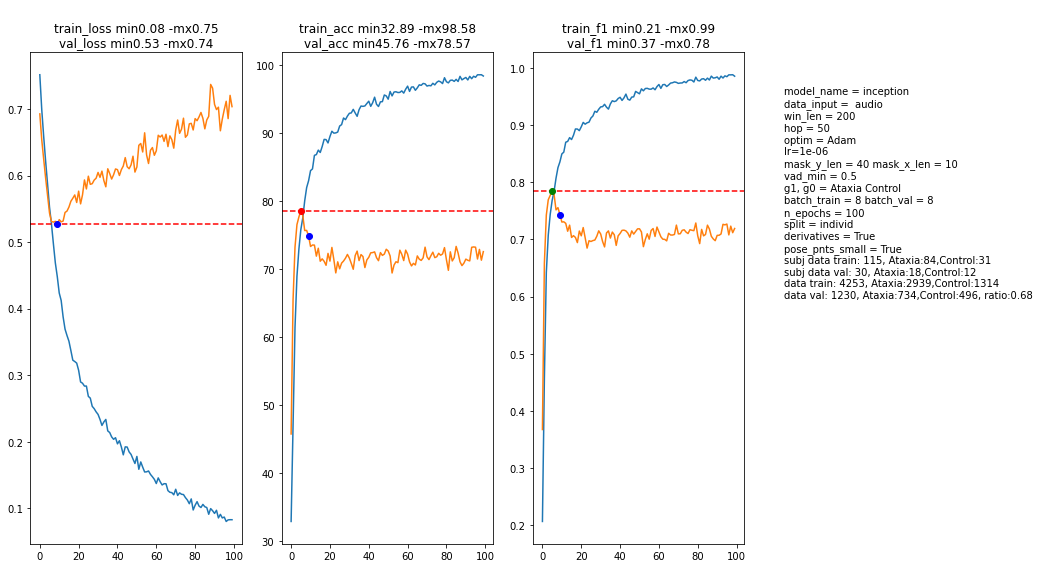

In [6]:
import numpy as np
import time
import pickle
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchaudio.transforms as T
from DL_utils import get_data, MyDataset, MyDataset_2data, inception_model, FCNN_short, binary_acc, multiinception_model

win_len = 100
hop = 100
vad_min = .5
g1, g0 = 'Ataxia', 'Control'
batch_train = 8
batch_val = 8  # all if -1
dev_num = 1
data_input =  "audio"  #  "multi" # "face" #
n_epochs = 100
split = 'individ'
optim = "Adam"  # "SGD"#
mask_y_len = 40
mask_x_len = 10
lr = 1e-6
model_name = "inception"  # "FCNN_short"
pose_pnts_small = True # "face_mouse" # "face_mouse" or True
derivatives= True
save = True

for win_len in [200]:
    for hop in [50 ]:
        params_string = f"model_name = {model_name} \ndata_input =  {data_input} \nwin_len = {win_len} \nhop = {hop} \noptim = {optim} \nlr={lr} \nmask_y_len = {mask_y_len} mask_x_len = {mask_x_len} \
        \nvad_min = {vad_min}  \ng1, g0 = {g1} {g0} \nbatch_train = {batch_train} batch_val = {batch_val}  \nn_epochs = {n_epochs} \
        \nsplit = {split} \nderivatives = {derivatives} \npose_pnts_small = {pose_pnts_small}"
        print(params_string)

        # Get dataset
        fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_flhNone-30_min_win4_audio_commFs50.pickle'
        # fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_dwnsmp-4_flhNone-30_audio.pickle'
        with open(fname, "rb") as f:
            dataset = pickle.load(f)

        if pose_pnts_small:
            # reduce num points face
            with open("inx_mp2op.pickle", "rb") as f:
                pnts_inx = pickle.load(f)
            if pose_pnts_small == "face_mouse":
                subset = np.arange(36, 70)
                pnts_inx = np.array(pnts_inx)[subset]
            for k in list(dataset)[:1]:
                dataset[k]['ts'] = [d[:, pnts_inx, :] for d in dataset[k]['ts']]

        # Remove other groups
        ids = list(dataset)
        for k in ids:
            if dataset[k]['beh']['gen_diagnosis'] not in [g1, g0]:
                del dataset[k]

        # Split data into groups
        ids = np.array(list(dataset))
        labels = [dataset[k]['beh']['gen_diagnosis'] for k in ids]
        labels = [1 if l == g1 else 0 for l in labels]


        if split == "strat":
            train_inx, val_inx = train_test_split(list(range(len(labels))), test_size=.3,
                                                random_state=1, stratify=labels)
        elif split == "individ":
            IDs = [i[:5] for i in list(dataset.keys())]
            idxs, inx, groups = np.unique(IDs, return_index=True, return_inverse=True)
            gss = GroupShuffleSplit(1, train_size=.8, random_state=1)
            train_inx, val_inx = next(
                gss.split(list(range(len(labels))), None, groups))

        data_train = {k: v for k, v in dataset.items() if k in ids[train_inx]}
        data_val = {k: v for k, v in dataset.items() if k in ids[val_inx]}

        labels = np.array(labels)
        
        l1 = f"subj data train: {len(data_train)}, {g1}:{sum(labels[train_inx]== 1)},{g0}:{sum(labels[train_inx]== 0)}"
        l2 = f"subj data val: {len(data_val)}, {g1}:{sum(labels[val_inx]== 1)},{g0}:{sum(labels[val_inx]== 0)}"
        print(l1)
        print(l2)
        
        x_ts_train, x_S_train, y_train, sbj_ids_train, inx_win = get_data(
            data_train, win_len, hop, vad_min, pose_dims=2,derivatives=derivatives)
        x_ts_val, x_S_val, y_val, sbj_ids_val, _ = get_data(
            data_val, win_len, hop, vad_min, pose_dims=2 ,derivatives=derivatives)
        
        y_train = [1 if l == g1 else 0 for l in y_train]
        y_val = [1 if l == g1 else 0 for l in y_val]

        val_1 = sum(y_val)
        val_0 = abs(val_1 - len(y_val))
        
        l3 = f"data train: {len(x_ts_train)}, {g1}:{sum(y_train)},{g0}:{abs(sum(y_train) - len(y_train))} "
        l4 = f"data val: {len(x_ts_val)}, {g1}:{val_1},{g0}:{val_0}, ratio:{val_0/val_1 :.2f} "
        print(l3)
        print(l4)
        
        # Create Dataloaders
        transform = transforms.Compose([
            T.TimeMasking(time_mask_param=mask_x_len),
            T.FrequencyMasking(freq_mask_param=mask_y_len)
        ])

        if data_input == "face":
            dataset_t = MyDataset(x_ts_train, y_train, transform=transform)
            dataset_v = MyDataset(x_ts_val, y_val, transform=transform)
        elif data_input == "audio":
            dataset_t = MyDataset(x_S_train, y_train, transform=transform)
            dataset_v = MyDataset(x_S_val, y_val, transform=transform)
        elif data_input == "multi":
            dataset_t = MyDataset_2data(
                x_ts_train, x_S_train, y_train, transform=transform)
            dataset_v = MyDataset_2data(x_ts_val, x_S_val, y_val, transform=transform)

        dataloader_t = DataLoader(dataset_t, batch_size=batch_train,
                                shuffle=True, drop_last=True, pin_memory=True)
        batch_size = len(dataset_v) if batch_val < 0 else batch_val
        dataloader_v = DataLoader(
            dataset_v, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        if device == "cuda" and dev_num is not None:
            device = torch.device(f'cuda:{dev_num}')

        # Set up ML
        if data_input == "multi":
            in_chans1 = dataloader_t.dataset.data_pose[0].shape[0]
            in_chans2 = dataloader_t.dataset.data_aud[0].shape[0]
            net = multiinception_model(in_chans1, in_chans2)
            net_name = "inception"
        elif model_name == "FCNN_short":
            net_name = model_name
            net = FCNN_short()
        else:
            in_chans = dataloader_t.dataset.data[0].shape[0]
            net = inception_model(in_chans)
            net_name = "inception"

        t0 = time.time()
        if device == "cuda" and dev_num is None:
            net = nn.DataParallel(net)
        net.to(device)

        criterion = nn.CrossEntropyLoss().to(device)
        if optim == "Adam":
            optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.01)
        elif optim == "SGD":
            optimizer = torch.optim.SGD(
                net.parameters(), lr=lr, momentum=0.9, weight_decay=0.01)

        train_f1 = torchmetrics.F1(num_classes=2, average='weighted')
        train_f1.to(device)
        metrics = {k: [] for k in ["train_loss", "train_acc",
                                "val_loss", "val_acc", "train_f1", "val_f1"]}
        for epoch in range(n_epochs):  # loop over the dataset multiple times

            running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
            for i, data in enumerate(dataloader_t):
                if data_input == "multi":
                    inputs1, inputs2, labels = data
                    inputs1 = inputs1.to(device)
                    inputs2 = inputs2.to(device)
                else:
                    inputs, labels = data
                    if model_name == "FCNN_short":
                        inputs = torch.unsqueeze(inputs, dim=1)
                    inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                labels = labels.type(torch.long)
                labels = labels.unsqueeze(1)
                
                # forward + backward + optimize
                if data_input == "multi":
                    outputs = net(inputs1, inputs2)
                else:
                    outputs = net(inputs)
                loss = criterion(outputs, labels[:, 0])

                outputs = torch.argmax(F.softmax(outputs, dim=1), dim=1)
                acc = binary_acc(outputs, labels[:, 0])
                f1 = train_f1(outputs, labels[:, 0])

                loss.backward()
                optimizer.step()

                running_f1 += f1.item()
                running_loss += loss.item()
                running_acc += acc.item()

            metrics["train_loss"].append(running_loss / len(dataloader_t))
            metrics["train_acc"].append(running_acc / len(dataloader_t))
            metrics["train_f1"].append(running_f1 / len(dataloader_t))

            running_loss, running_acc, running_f1 = 0.0, 0., 0.0
            for i, data in enumerate(dataloader_v):
                if data_input == "multi":
                    inputs1, inputs2, labels = data
                    inputs1 = inputs1.to(device)
                    inputs2 = inputs2.to(device)
                else:
                    inputs, labels = data
                    if model_name == "FCNN_short":
                        inputs = torch.unsqueeze(inputs, dim=1)
                    inputs = inputs.to(device)
                labels = labels.to(device)

                labels = labels.type(torch.long)
                labels = labels.unsqueeze(1)

                # forward
                if data_input == "multi":
                    outputs = net(inputs1, inputs2)
                else:
                    outputs = net(inputs)
                loss = criterion(outputs, labels[:, 0])

                outputs = torch.argmax(F.softmax(outputs, dim=1), dim=1)
                acc = binary_acc(outputs, labels[:, 0])
                f1 = train_f1(outputs, labels[:, 0])

                running_f1 += f1.item()
                running_loss += loss.item()
                running_acc += acc.item()

            metrics["val_loss"].append(running_loss / len(dataloader_v))
            metrics["val_acc"].append(running_acc / len(dataloader_v))
            metrics["val_f1"].append(running_f1 / len(dataloader_v))

            # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
            #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
            #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
            #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
            #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
            #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

        t1 = time.time()
        ttot = t1 - t0
        print(f'Finished Training in {ttot/60}')


        title = net_name

        fig, axs = plt.subplots(1, 4, figsize=(15, 8))
        # fig.canvas.set_window_title(title)
        for ax, tt in zip(axs.flatten(), ['train_loss', 'train_acc', 'train_f1']):
            ax.plot(metrics[tt])
            mn, mx = min(metrics[tt]), max(metrics[tt])
            ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
            
        for ax, tt in zip(axs.flatten(), ['val_loss', 'val_acc',  "val_f1"]):
            ax.plot(metrics[tt])
            mn, mx = min(metrics[tt]), max(metrics[tt])
            tt =  "\n" + ax.get_title() + "\n" + tt
            ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
            
        print(f"Maxx val acc: {max(metrics['val_acc'])}")
        axs.flatten()[0].axhline(min(metrics['val_loss']), color="r", linestyle="--")
        loss_min = np.argmin(metrics['val_loss'])
        axs.flatten()[0].plot(loss_min, min(metrics['val_loss']), "bo")
        axs.flatten()[1].plot(loss_min, metrics['val_acc'][loss_min], "bo")
        axs.flatten()[2].plot(loss_min, metrics['val_f1'][loss_min], "bo")

        axs.flatten()[1].axhline(max(metrics['val_acc']), color="r", linestyle="--")
        axs.flatten()[1].plot(np.argmax(metrics['val_acc']),
                            max(metrics['val_acc']), "ro")

        axs.flatten()[2].axhline(max(metrics['val_f1']), color="r", linestyle="--")
        axs.flatten()[2].plot(np.argmax(metrics['val_f1']),
                            max(metrics['val_f1']), "go")

        axs[3].axis('off')
        axs[3].text(0,.5, params_string + f'\n{l1}\n{l2}\n{l3}\n{l4}')
        
        fig.tight_layout()
        fig.show()
        
        if save:
            fig.savefig(f"result_figs/{title}_{data_input}_{win_len}wz_{hop}st_{g1}vs{g0}_mask_y_len{mask_y_len}_mask_x_len{mask_x_len}_lr{lr}_deriv{derivatives}_pntsubset{pose_pnts_small}_optim{optim}_valBatch{batch_val}_{round(ttot/60)}mintime.png")

model_name = inception 
data_input =  audio 
win_len = 200 
hop = 100 
optim = Adam 
lr=1e-06 
mask_y_len = 40 mask_x_len = 10         
vad_min = 0.5  
g1, g0 = Ataxia Control 
batch_train = 8 batch_val = 8  
n_epochs = 100         
split = individ 
derivatives = True 
pose_pnts_small = True
subj data train: 115, Ataxia:84,Control:31
subj data val: 30, Ataxia:18,Control:12
data train: 2144, Ataxia:1479,Control:665 
data val: 616, Ataxia:365,Control:251, ratio:0.69 
Finished Training in 9.231483948230743
Maxx val acc: 72.76623376623377


<ipython-input-7-1e63355d1afb>:284: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


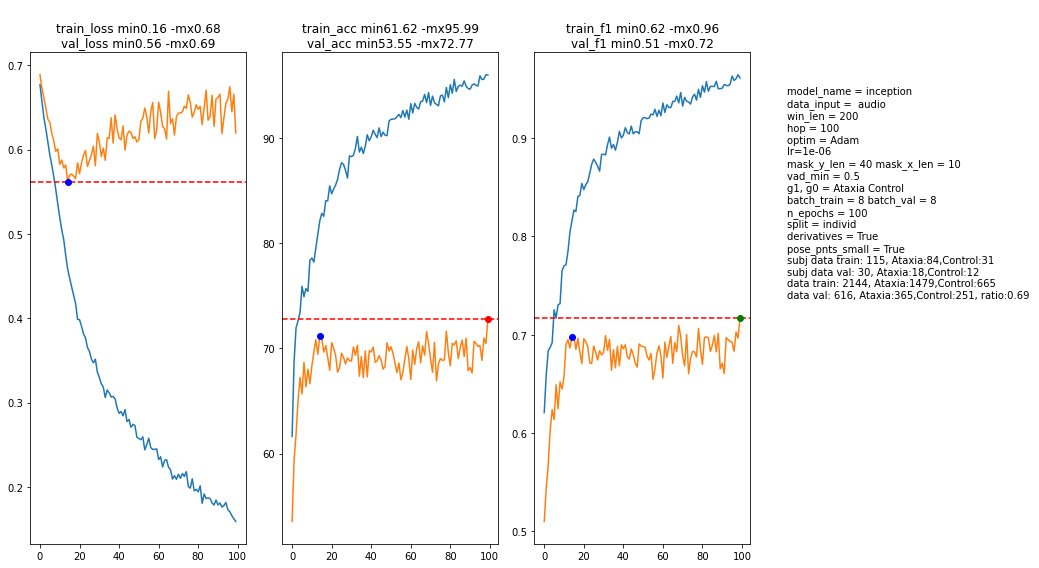

In [7]:
import numpy as np
import time
import pickle
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchaudio.transforms as T
from DL_utils import get_data, MyDataset, MyDataset_2data, inception_model, FCNN_short, binary_acc, multiinception_model

win_len = 100
hop = 100
vad_min = .5
g1, g0 = 'Ataxia', 'Control'
batch_train = 8
batch_val = 8  # all if -1
dev_num = 1
data_input =  "audio"  #  "multi" # "face" #
n_epochs = 100
split = 'individ'
optim = "Adam"  # "SGD"#
mask_y_len = 40
mask_x_len = 10
lr = 1e-6
model_name = "inception"  # "FCNN_short"
pose_pnts_small = True # "face_mouse" # "face_mouse" or True
derivatives= True
save = True

for win_len in [200]:
    for hop in [100 ]:
        params_string = f"model_name = {model_name} \ndata_input =  {data_input} \nwin_len = {win_len} \nhop = {hop} \noptim = {optim} \nlr={lr} \nmask_y_len = {mask_y_len} mask_x_len = {mask_x_len} \
        \nvad_min = {vad_min}  \ng1, g0 = {g1} {g0} \nbatch_train = {batch_train} batch_val = {batch_val}  \nn_epochs = {n_epochs} \
        \nsplit = {split} \nderivatives = {derivatives} \npose_pnts_small = {pose_pnts_small}"
        print(params_string)

        # Get dataset
        fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_flhNone-30_min_win4_audio_commFs50.pickle'
        # fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_dwnsmp-4_flhNone-30_audio.pickle'
        with open(fname, "rb") as f:
            dataset = pickle.load(f)

        if pose_pnts_small:
            # reduce num points face
            with open("inx_mp2op.pickle", "rb") as f:
                pnts_inx = pickle.load(f)
            if pose_pnts_small == "face_mouse":
                subset = np.arange(36, 70)
                pnts_inx = np.array(pnts_inx)[subset]
            for k in list(dataset)[:1]:
                dataset[k]['ts'] = [d[:, pnts_inx, :] for d in dataset[k]['ts']]

        # Remove other groups
        ids = list(dataset)
        for k in ids:
            if dataset[k]['beh']['gen_diagnosis'] not in [g1, g0]:
                del dataset[k]

        # Split data into groups
        ids = np.array(list(dataset))
        labels = [dataset[k]['beh']['gen_diagnosis'] for k in ids]
        labels = [1 if l == g1 else 0 for l in labels]


        if split == "strat":
            train_inx, val_inx = train_test_split(list(range(len(labels))), test_size=.3,
                                                random_state=1, stratify=labels)
        elif split == "individ":
            IDs = [i[:5] for i in list(dataset.keys())]
            idxs, inx, groups = np.unique(IDs, return_index=True, return_inverse=True)
            gss = GroupShuffleSplit(1, train_size=.8, random_state=1)
            train_inx, val_inx = next(
                gss.split(list(range(len(labels))), None, groups))

        data_train = {k: v for k, v in dataset.items() if k in ids[train_inx]}
        data_val = {k: v for k, v in dataset.items() if k in ids[val_inx]}

        labels = np.array(labels)
        
        l1 = f"subj data train: {len(data_train)}, {g1}:{sum(labels[train_inx]== 1)},{g0}:{sum(labels[train_inx]== 0)}"
        l2 = f"subj data val: {len(data_val)}, {g1}:{sum(labels[val_inx]== 1)},{g0}:{sum(labels[val_inx]== 0)}"
        print(l1)
        print(l2)
        
        x_ts_train, x_S_train, y_train, sbj_ids_train, inx_win = get_data(
            data_train, win_len, hop, vad_min, pose_dims=2,derivatives=derivatives)
        x_ts_val, x_S_val, y_val, sbj_ids_val, _ = get_data(
            data_val, win_len, hop, vad_min, pose_dims=2 ,derivatives=derivatives)
        
        y_train = [1 if l == g1 else 0 for l in y_train]
        y_val = [1 if l == g1 else 0 for l in y_val]

        val_1 = sum(y_val)
        val_0 = abs(val_1 - len(y_val))
        
        l3 = f"data train: {len(x_ts_train)}, {g1}:{sum(y_train)},{g0}:{abs(sum(y_train) - len(y_train))} "
        l4 = f"data val: {len(x_ts_val)}, {g1}:{val_1},{g0}:{val_0}, ratio:{val_0/val_1 :.2f} "
        print(l3)
        print(l4)
        
        # Create Dataloaders
        transform = transforms.Compose([
            T.TimeMasking(time_mask_param=mask_x_len),
            T.FrequencyMasking(freq_mask_param=mask_y_len)
        ])

        if data_input == "face":
            dataset_t = MyDataset(x_ts_train, y_train, transform=transform)
            dataset_v = MyDataset(x_ts_val, y_val, transform=transform)
        elif data_input == "audio":
            dataset_t = MyDataset(x_S_train, y_train, transform=transform)
            dataset_v = MyDataset(x_S_val, y_val, transform=transform)
        elif data_input == "multi":
            dataset_t = MyDataset_2data(
                x_ts_train, x_S_train, y_train, transform=transform)
            dataset_v = MyDataset_2data(x_ts_val, x_S_val, y_val, transform=transform)

        dataloader_t = DataLoader(dataset_t, batch_size=batch_train,
                                shuffle=True, drop_last=True, pin_memory=True)
        batch_size = len(dataset_v) if batch_val < 0 else batch_val
        dataloader_v = DataLoader(
            dataset_v, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        if device == "cuda" and dev_num is not None:
            device = torch.device(f'cuda:{dev_num}')

        # Set up ML
        if data_input == "multi":
            in_chans1 = dataloader_t.dataset.data_pose[0].shape[0]
            in_chans2 = dataloader_t.dataset.data_aud[0].shape[0]
            net = multiinception_model(in_chans1, in_chans2)
            net_name = "inception"
        elif model_name == "FCNN_short":
            net_name = model_name
            net = FCNN_short()
        else:
            in_chans = dataloader_t.dataset.data[0].shape[0]
            net = inception_model(in_chans)
            net_name = "inception"

        t0 = time.time()
        if device == "cuda" and dev_num is None:
            net = nn.DataParallel(net)
        net.to(device)

        criterion = nn.CrossEntropyLoss().to(device)
        if optim == "Adam":
            optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.01)
        elif optim == "SGD":
            optimizer = torch.optim.SGD(
                net.parameters(), lr=lr, momentum=0.9, weight_decay=0.01)

        train_f1 = torchmetrics.F1(num_classes=2, average='weighted')
        train_f1.to(device)
        metrics = {k: [] for k in ["train_loss", "train_acc",
                                "val_loss", "val_acc", "train_f1", "val_f1"]}
        for epoch in range(n_epochs):  # loop over the dataset multiple times

            running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
            for i, data in enumerate(dataloader_t):
                if data_input == "multi":
                    inputs1, inputs2, labels = data
                    inputs1 = inputs1.to(device)
                    inputs2 = inputs2.to(device)
                else:
                    inputs, labels = data
                    if model_name == "FCNN_short":
                        inputs = torch.unsqueeze(inputs, dim=1)
                    inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                labels = labels.type(torch.long)
                labels = labels.unsqueeze(1)
                
                # forward + backward + optimize
                if data_input == "multi":
                    outputs = net(inputs1, inputs2)
                else:
                    outputs = net(inputs)
                loss = criterion(outputs, labels[:, 0])

                outputs = torch.argmax(F.softmax(outputs, dim=1), dim=1)
                acc = binary_acc(outputs, labels[:, 0])
                f1 = train_f1(outputs, labels[:, 0])

                loss.backward()
                optimizer.step()

                running_f1 += f1.item()
                running_loss += loss.item()
                running_acc += acc.item()

            metrics["train_loss"].append(running_loss / len(dataloader_t))
            metrics["train_acc"].append(running_acc / len(dataloader_t))
            metrics["train_f1"].append(running_f1 / len(dataloader_t))

            running_loss, running_acc, running_f1 = 0.0, 0., 0.0
            for i, data in enumerate(dataloader_v):
                if data_input == "multi":
                    inputs1, inputs2, labels = data
                    inputs1 = inputs1.to(device)
                    inputs2 = inputs2.to(device)
                else:
                    inputs, labels = data
                    if model_name == "FCNN_short":
                        inputs = torch.unsqueeze(inputs, dim=1)
                    inputs = inputs.to(device)
                labels = labels.to(device)

                labels = labels.type(torch.long)
                labels = labels.unsqueeze(1)

                # forward
                if data_input == "multi":
                    outputs = net(inputs1, inputs2)
                else:
                    outputs = net(inputs)
                loss = criterion(outputs, labels[:, 0])

                outputs = torch.argmax(F.softmax(outputs, dim=1), dim=1)
                acc = binary_acc(outputs, labels[:, 0])
                f1 = train_f1(outputs, labels[:, 0])

                running_f1 += f1.item()
                running_loss += loss.item()
                running_acc += acc.item()

            metrics["val_loss"].append(running_loss / len(dataloader_v))
            metrics["val_acc"].append(running_acc / len(dataloader_v))
            metrics["val_f1"].append(running_f1 / len(dataloader_v))

            # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
            #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
            #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
            #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
            #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
            #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

        t1 = time.time()
        ttot = t1 - t0
        print(f'Finished Training in {ttot/60}')


        title = net_name

        fig, axs = plt.subplots(1, 4, figsize=(15, 8))
        # fig.canvas.set_window_title(title)
        for ax, tt in zip(axs.flatten(), ['train_loss', 'train_acc', 'train_f1']):
            ax.plot(metrics[tt])
            mn, mx = min(metrics[tt]), max(metrics[tt])
            ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
            
        for ax, tt in zip(axs.flatten(), ['val_loss', 'val_acc',  "val_f1"]):
            ax.plot(metrics[tt])
            mn, mx = min(metrics[tt]), max(metrics[tt])
            tt =  "\n" + ax.get_title() + "\n" + tt
            ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
            
        print(f"Maxx val acc: {max(metrics['val_acc'])}")
        axs.flatten()[0].axhline(min(metrics['val_loss']), color="r", linestyle="--")
        loss_min = np.argmin(metrics['val_loss'])
        axs.flatten()[0].plot(loss_min, min(metrics['val_loss']), "bo")
        axs.flatten()[1].plot(loss_min, metrics['val_acc'][loss_min], "bo")
        axs.flatten()[2].plot(loss_min, metrics['val_f1'][loss_min], "bo")

        axs.flatten()[1].axhline(max(metrics['val_acc']), color="r", linestyle="--")
        axs.flatten()[1].plot(np.argmax(metrics['val_acc']),
                            max(metrics['val_acc']), "ro")

        axs.flatten()[2].axhline(max(metrics['val_f1']), color="r", linestyle="--")
        axs.flatten()[2].plot(np.argmax(metrics['val_f1']),
                            max(metrics['val_f1']), "go")

        axs[3].axis('off')
        axs[3].text(0,.5, params_string + f'\n{l1}\n{l2}\n{l3}\n{l4}')
        
        fig.tight_layout()
        fig.show()
        
        if save:
            fig.savefig(f"result_figs/{title}_{data_input}_{win_len}wz_{hop}st_{g1}vs{g0}_mask_y_len{mask_y_len}_mask_x_len{mask_x_len}_lr{lr}_deriv{derivatives}_pntsubset{pose_pnts_small}_optim{optim}_valBatch{batch_val}_{round(ttot/60)}mintime.png")

model_name = inception 
data_input =  audio 
win_len = 200 
hop = 10 
optim = Adam 
lr=1e-06 
mask_y_len = 40 mask_x_len = 10         
vad_min = 0.5  
g1, g0 = Ataxia Control 
batch_train = 8 batch_val = 8  
n_epochs = 100         
split = individ 
derivatives = True 
pose_pnts_small = True
subj data train: 115, Ataxia:84,Control:31
subj data val: 30, Ataxia:18,Control:12
data train: 21115, Ataxia:14597,Control:6518 
data val: 6087, Ataxia:3630,Control:2457, ratio:0.68 
Finished Training in 90.03591961065928
Maxx val acc: 74.6328947368421


<ipython-input-8-636b9b29cd51>:284: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


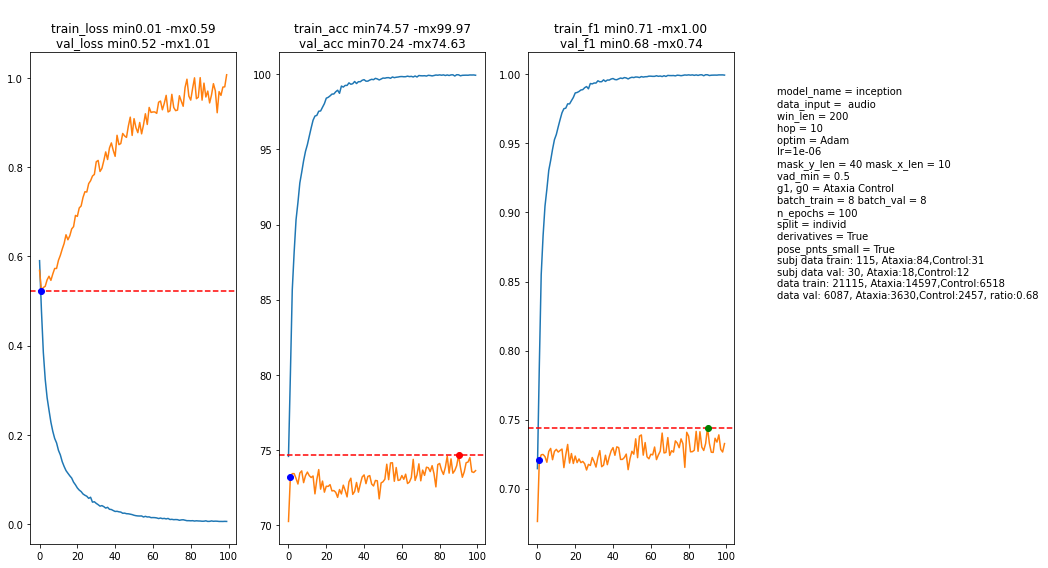

In [8]:
import numpy as np
import time
import pickle
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchaudio.transforms as T
from DL_utils import get_data, MyDataset, MyDataset_2data, inception_model, FCNN_short, binary_acc, multiinception_model

win_len = 100
hop = 100
vad_min = .5
g1, g0 = 'Ataxia', 'Control'
batch_train = 8
batch_val = 8  # all if -1
dev_num = 1
data_input =  "audio"  #  "multi" # "face" #
n_epochs = 100
split = 'individ'
optim = "Adam"  # "SGD"#
mask_y_len = 40
mask_x_len = 10
lr = 1e-6
model_name = "inception"  # "FCNN_short"
pose_pnts_small = True # "face_mouse" # "face_mouse" or True
derivatives= True
save = True

for win_len in [200]:
    for hop in [10 ]:
        params_string = f"model_name = {model_name} \ndata_input =  {data_input} \nwin_len = {win_len} \nhop = {hop} \noptim = {optim} \nlr={lr} \nmask_y_len = {mask_y_len} mask_x_len = {mask_x_len} \
        \nvad_min = {vad_min}  \ng1, g0 = {g1} {g0} \nbatch_train = {batch_train} batch_val = {batch_val}  \nn_epochs = {n_epochs} \
        \nsplit = {split} \nderivatives = {derivatives} \npose_pnts_small = {pose_pnts_small}"
        print(params_string)

        # Get dataset
        fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_flhNone-30_min_win4_audio_commFs50.pickle'
        # fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_dwnsmp-4_flhNone-30_audio.pickle'
        with open(fname, "rb") as f:
            dataset = pickle.load(f)

        if pose_pnts_small:
            # reduce num points face
            with open("inx_mp2op.pickle", "rb") as f:
                pnts_inx = pickle.load(f)
            if pose_pnts_small == "face_mouse":
                subset = np.arange(36, 70)
                pnts_inx = np.array(pnts_inx)[subset]
            for k in list(dataset)[:1]:
                dataset[k]['ts'] = [d[:, pnts_inx, :] for d in dataset[k]['ts']]

        # Remove other groups
        ids = list(dataset)
        for k in ids:
            if dataset[k]['beh']['gen_diagnosis'] not in [g1, g0]:
                del dataset[k]

        # Split data into groups
        ids = np.array(list(dataset))
        labels = [dataset[k]['beh']['gen_diagnosis'] for k in ids]
        labels = [1 if l == g1 else 0 for l in labels]


        if split == "strat":
            train_inx, val_inx = train_test_split(list(range(len(labels))), test_size=.3,
                                                random_state=1, stratify=labels)
        elif split == "individ":
            IDs = [i[:5] for i in list(dataset.keys())]
            idxs, inx, groups = np.unique(IDs, return_index=True, return_inverse=True)
            gss = GroupShuffleSplit(1, train_size=.8, random_state=1)
            train_inx, val_inx = next(
                gss.split(list(range(len(labels))), None, groups))

        data_train = {k: v for k, v in dataset.items() if k in ids[train_inx]}
        data_val = {k: v for k, v in dataset.items() if k in ids[val_inx]}

        labels = np.array(labels)
        
        l1 = f"subj data train: {len(data_train)}, {g1}:{sum(labels[train_inx]== 1)},{g0}:{sum(labels[train_inx]== 0)}"
        l2 = f"subj data val: {len(data_val)}, {g1}:{sum(labels[val_inx]== 1)},{g0}:{sum(labels[val_inx]== 0)}"
        print(l1)
        print(l2)
        
        x_ts_train, x_S_train, y_train, sbj_ids_train, inx_win = get_data(
            data_train, win_len, hop, vad_min, pose_dims=2,derivatives=derivatives)
        x_ts_val, x_S_val, y_val, sbj_ids_val, _ = get_data(
            data_val, win_len, hop, vad_min, pose_dims=2 ,derivatives=derivatives)
        
        y_train = [1 if l == g1 else 0 for l in y_train]
        y_val = [1 if l == g1 else 0 for l in y_val]

        val_1 = sum(y_val)
        val_0 = abs(val_1 - len(y_val))
        
        l3 = f"data train: {len(x_ts_train)}, {g1}:{sum(y_train)},{g0}:{abs(sum(y_train) - len(y_train))} "
        l4 = f"data val: {len(x_ts_val)}, {g1}:{val_1},{g0}:{val_0}, ratio:{val_0/val_1 :.2f} "
        print(l3)
        print(l4)
        
        # Create Dataloaders
        transform = transforms.Compose([
            T.TimeMasking(time_mask_param=mask_x_len),
            T.FrequencyMasking(freq_mask_param=mask_y_len)
        ])

        if data_input == "face":
            dataset_t = MyDataset(x_ts_train, y_train, transform=transform)
            dataset_v = MyDataset(x_ts_val, y_val, transform=transform)
        elif data_input == "audio":
            dataset_t = MyDataset(x_S_train, y_train, transform=transform)
            dataset_v = MyDataset(x_S_val, y_val, transform=transform)
        elif data_input == "multi":
            dataset_t = MyDataset_2data(
                x_ts_train, x_S_train, y_train, transform=transform)
            dataset_v = MyDataset_2data(x_ts_val, x_S_val, y_val, transform=transform)

        dataloader_t = DataLoader(dataset_t, batch_size=batch_train,
                                shuffle=True, drop_last=True, pin_memory=True)
        batch_size = len(dataset_v) if batch_val < 0 else batch_val
        dataloader_v = DataLoader(
            dataset_v, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        if device == "cuda" and dev_num is not None:
            device = torch.device(f'cuda:{dev_num}')

        # Set up ML
        if data_input == "multi":
            in_chans1 = dataloader_t.dataset.data_pose[0].shape[0]
            in_chans2 = dataloader_t.dataset.data_aud[0].shape[0]
            net = multiinception_model(in_chans1, in_chans2)
            net_name = "inception"
        elif model_name == "FCNN_short":
            net_name = model_name
            net = FCNN_short()
        else:
            in_chans = dataloader_t.dataset.data[0].shape[0]
            net = inception_model(in_chans)
            net_name = "inception"

        t0 = time.time()
        if device == "cuda" and dev_num is None:
            net = nn.DataParallel(net)
        net.to(device)

        criterion = nn.CrossEntropyLoss().to(device)
        if optim == "Adam":
            optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.01)
        elif optim == "SGD":
            optimizer = torch.optim.SGD(
                net.parameters(), lr=lr, momentum=0.9, weight_decay=0.01)

        train_f1 = torchmetrics.F1(num_classes=2, average='weighted')
        train_f1.to(device)
        metrics = {k: [] for k in ["train_loss", "train_acc",
                                "val_loss", "val_acc", "train_f1", "val_f1"]}
        for epoch in range(n_epochs):  # loop over the dataset multiple times

            running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
            for i, data in enumerate(dataloader_t):
                if data_input == "multi":
                    inputs1, inputs2, labels = data
                    inputs1 = inputs1.to(device)
                    inputs2 = inputs2.to(device)
                else:
                    inputs, labels = data
                    if model_name == "FCNN_short":
                        inputs = torch.unsqueeze(inputs, dim=1)
                    inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                labels = labels.type(torch.long)
                labels = labels.unsqueeze(1)
                
                # forward + backward + optimize
                if data_input == "multi":
                    outputs = net(inputs1, inputs2)
                else:
                    outputs = net(inputs)
                loss = criterion(outputs, labels[:, 0])

                outputs = torch.argmax(F.softmax(outputs, dim=1), dim=1)
                acc = binary_acc(outputs, labels[:, 0])
                f1 = train_f1(outputs, labels[:, 0])

                loss.backward()
                optimizer.step()

                running_f1 += f1.item()
                running_loss += loss.item()
                running_acc += acc.item()

            metrics["train_loss"].append(running_loss / len(dataloader_t))
            metrics["train_acc"].append(running_acc / len(dataloader_t))
            metrics["train_f1"].append(running_f1 / len(dataloader_t))

            running_loss, running_acc, running_f1 = 0.0, 0., 0.0
            for i, data in enumerate(dataloader_v):
                if data_input == "multi":
                    inputs1, inputs2, labels = data
                    inputs1 = inputs1.to(device)
                    inputs2 = inputs2.to(device)
                else:
                    inputs, labels = data
                    if model_name == "FCNN_short":
                        inputs = torch.unsqueeze(inputs, dim=1)
                    inputs = inputs.to(device)
                labels = labels.to(device)

                labels = labels.type(torch.long)
                labels = labels.unsqueeze(1)

                # forward
                if data_input == "multi":
                    outputs = net(inputs1, inputs2)
                else:
                    outputs = net(inputs)
                loss = criterion(outputs, labels[:, 0])

                outputs = torch.argmax(F.softmax(outputs, dim=1), dim=1)
                acc = binary_acc(outputs, labels[:, 0])
                f1 = train_f1(outputs, labels[:, 0])

                running_f1 += f1.item()
                running_loss += loss.item()
                running_acc += acc.item()

            metrics["val_loss"].append(running_loss / len(dataloader_v))
            metrics["val_acc"].append(running_acc / len(dataloader_v))
            metrics["val_f1"].append(running_f1 / len(dataloader_v))

            # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
            #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
            #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
            #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
            #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
            #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

        t1 = time.time()
        ttot = t1 - t0
        print(f'Finished Training in {ttot/60}')


        title = net_name

        fig, axs = plt.subplots(1, 4, figsize=(15, 8))
        # fig.canvas.set_window_title(title)
        for ax, tt in zip(axs.flatten(), ['train_loss', 'train_acc', 'train_f1']):
            ax.plot(metrics[tt])
            mn, mx = min(metrics[tt]), max(metrics[tt])
            ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
            
        for ax, tt in zip(axs.flatten(), ['val_loss', 'val_acc',  "val_f1"]):
            ax.plot(metrics[tt])
            mn, mx = min(metrics[tt]), max(metrics[tt])
            tt =  "\n" + ax.get_title() + "\n" + tt
            ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
            
        print(f"Maxx val acc: {max(metrics['val_acc'])}")
        axs.flatten()[0].axhline(min(metrics['val_loss']), color="r", linestyle="--")
        loss_min = np.argmin(metrics['val_loss'])
        axs.flatten()[0].plot(loss_min, min(metrics['val_loss']), "bo")
        axs.flatten()[1].plot(loss_min, metrics['val_acc'][loss_min], "bo")
        axs.flatten()[2].plot(loss_min, metrics['val_f1'][loss_min], "bo")

        axs.flatten()[1].axhline(max(metrics['val_acc']), color="r", linestyle="--")
        axs.flatten()[1].plot(np.argmax(metrics['val_acc']),
                            max(metrics['val_acc']), "ro")

        axs.flatten()[2].axhline(max(metrics['val_f1']), color="r", linestyle="--")
        axs.flatten()[2].plot(np.argmax(metrics['val_f1']),
                            max(metrics['val_f1']), "go")

        axs[3].axis('off')
        axs[3].text(0,.5, params_string + f'\n{l1}\n{l2}\n{l3}\n{l4}')
        
        fig.tight_layout()
        fig.show()
        
        if save:
            fig.savefig(f"result_figs/{title}_{data_input}_{win_len}wz_{hop}st_{g1}vs{g0}_mask_y_len{mask_y_len}_mask_x_len{mask_x_len}_lr{lr}_deriv{derivatives}_pntsubset{pose_pnts_small}_optim{optim}_valBatch{batch_val}_{round(ttot/60)}mintime.png")